## Part One: Data Preprocessing

In [115]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

# TODO: Read the CSV using pandas
df = pd.read_csv('pitching.csv')

# TODO: drop any year before 1985
df = df[df["yearID"] >= 1985]

# TODO: drop the first five columns
df = df.drop(columns=df.columns[:5])

# TODO: drop the last 3 columns
df = df.drop(columns=df.columns[-3:])

# TODO: drop blank / na rows
df = df.dropna()

# TODO: save ERA into its own vector, then drop it from the dataframe
era_vector = df["ERA"].values
df = df.drop(columns=["ERA"])

## Part 2: K-Means Implementation
You asked for it, and we delivered (well, okay, maybe only Blaine asked for it, but still)! Introducing method declarations with strong typing and docstring comments!

In [116]:
# TODO: Implement the K-Means algorithm. You're given starter functions, declarations, 
# and some code to get you started. The final implementation is up to you, but keep in
# mind that the visualization function we've built for you expects a list of pandas
# dataframes. Even though we provide method signatures, you may change them however you
# please. You're also free to change the visualization function to adapt to your changes, 
# but we feel it would be best to return the clusters from the K-Means function as a list 
# of dataframes. 

# You will be asked to generate a kmeans algorithm that works across all dimension spaces
# (i.e. 2D, 3D, etc.). Due to the sheer amount of features available in the pitching
# dataset, we want to be able to use clustering on every datapoint and every feature.

def initalize_points(num_clusters: int, dimensions: int,):
    ''' 
    Initializes random starting positions for each cluster's centroid. Each value in each point should 
    be rounded to two digits (i.e. x=10.72, y=4.36, etc.)

    Arguments:
        num_clusters (int): the total amount of clusters the k-means algorithm is looking for
        dimensions (int): the total amount of features

    Returns: 
        a list of points in the given dimension space [(x, y, z, ...), ...] 
    '''
    centroids = [] 
    features = df.columns
    
    for i in range(num_clusters):  
        centroid = [] 
        # for each cluster selecting a random centroid value
        #getting a random value between the min and max value of each feature
        #each random value together forms centroid
        for feature in features:
            min_value = df[feature].min()
            max_value = df[feature].max()
            random_value = round(np.random.uniform(min_value, max_value), 2)
            centroid.append(random_value)
        centroids.append(centroid)
    
    return centroids

def distance(point1: list[float], point2: list[float]):
    '''
    Given two points in the given dimension space (x, y, z, ...), calculates the euclidean distance between them

    Arguments:
        point1: a list of floating point numbers representing a point in the given dimension space
        point2: a list of floating point numbers representing a point in the given dimension space 

    Returns:
        the euclidean distance between point1 and point2

    '''
    # If you are unfamiliar with calculating distance in any dimension space, this link may be helpful:
    # https://www.geeksforgeeks.org/euclidean-distance/#:~:text=Euclidean%20Distance%20in%20nD
    
    inside_sum = 0  

    #euclidean distance between point 1 and point 2
    for i in range(len(point1)):
        difference = point1[i] - point2[i]
        inside_sum += difference ** 2 
    return math.sqrt(inside_sum)

def assign_clusters(centroids: list[list[float]], data: pd.DataFrame):
    '''
    Calculates the distance between every datapoint and every centroid. Assigns a cluster
    to a datapoint if that cluster's centroid is the closest. 

    Arguments:
        centroids (list[list[float]]): A list of points in given dimension space [(x, y, z, ...), ...] that represent the center of a cluster
        data (pd.DataFrame): the input data

    Returns:
        a copy of the data with a "cluster" column which assigns a cluster to each datapoint
    '''
    cluster_assignments = []  

    for data_point in range(len(data)): 
        point = data.iloc[data_point].values.tolist()  
        closest_cluster = None  
        min_distance = float('inf') 

        #calculating distance between each data point and current centroid
        for i in range(len(centroids)): 
            centroid = centroids[i]  
            distance_point_centroid = distance(point, centroid) 
            if distance_point_centroid < min_distance:  
                min_distance = distance_point_centroid 
                #index of centroid with minimum distance is the data points assigned cluster
                closest_cluster = i 
        cluster_assignments.append(closest_cluster)

    df_with_cluster = data.copy()
    df_with_cluster['Cluster'] = cluster_assignments

    return df_with_cluster

def move_centroids(centroids: list[list[float]], data: pd.DataFrame):
    '''
    Moves all centroids to the midpoint of their respective datapoints. 
    HINT: Average each column's values respective to each cluster!

    Arguments:
        centroids (list[list[float]]): A list of points in given dimension space [(x, y, z, ...), ...] that represent the center of a cluster
        data (pd.DataFrame): the input data 
    '''

    #data in the cluster column is grouped by clusters
    #calculating the mean of each feature for each cluster
    grouped_means = data.groupby("Cluster").mean()

    new_centroids = []
    for i in range(len(centroids)):
        #for each exisiting centroid, if the cluster exists in grouped means, the mean values of the points for that cluster become the new centroid
        if i in grouped_means.index:
            new_centroids.append(grouped_means.loc[i].tolist())
        #if the cluster has no assigned points, the centroid is not changed
        else:
            new_centroids.append(centroids[i])
    
    return new_centroids

def kmeans(num_clusters: int, data: pd.DataFrame, num_iterations: int):
    '''
    Implementation of the k-means algorithm. Consists of the following steps:
    1. Initialize a set of points to be the centroids of the clusters
    2. Iterate for num_iterations times:
        * Assign clusters to datapoints 
        * Move all centroids relative to their assigned datapoints
    3. Return a list of clusters with their assigned datapoints 

    Arguments:
        num_clusters (int): the total amount of clusters the k-means algorithm is looking for
        data (pd.DataFrame): the input data
        num_iterations (int): the total amount of times we move and assign clusters 

    Returns:
        a list of dataframes, each dataframe representing a cluster of datapoints
    '''
    #getting starting random centroids
    centroids = initalize_points(num_clusters, data)
    
    #assign initial clusters
    #find new centroid locations based on current assignments
    for i in range(num_iterations):
        data_with_clusters = assign_clusters(centroids, data)
        centroids = move_centroids(centroids, data_with_clusters)

    #groups data points into final clusters
    clusters = []    
    for i in range(num_clusters):
        cluster_data = data_with_clusters[data_with_clusters["Cluster"] == i]
        clusters.append(cluster_data)
    
    return clusters

## Part 3: Optimal K Selection

In [117]:
from sklearn.cluster import KMeans

def plot_elbow_curve(data: pd.DataFrame, num_iterations=10, num_max_iter=300):
    sse = []

    for i in range(1,11):
        num_c = i # clusters

        # initialize k-means
        km = KMeans(n_clusters=num_c, n_init=num_iterations, max_iter=num_max_iter)

        # fit and predict
        y_km = km.fit_predict(data)

        sse.append(km.inertia_)

    # plot elbow graph
    plt.plot(sse)
    # reset x ticks to match num_clusters
    plt.xticks(range(0,10), range(1,11))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Graph: Inertia vs # Clusters')
    plt.show()

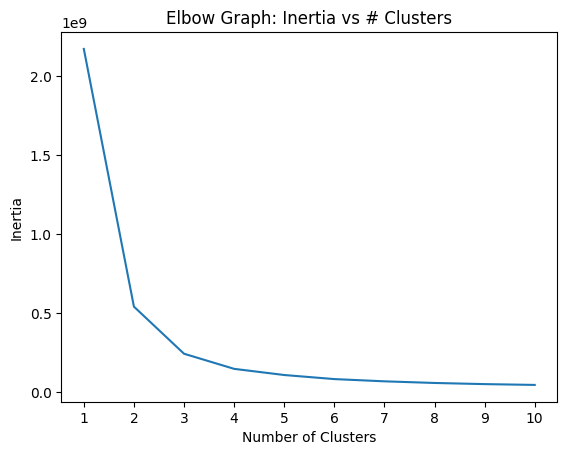

In [118]:
# TODO: Determine k by running plot_elbow_curve on your dataframe of pitching data!
plot_elbow_curve(df)

In [119]:
def visualize_clusters(clusters: list[pd.DataFrame]):
    '''
    Visualizes the list of clusters provided in a 3D projection. Separates clusters into color groupings.

    Arguments:
        clusters (list[pd.DataFrame]): a list of clusters provided by running the k-means algorithm 
    '''
    # plot clusters
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    # add each cluster to graph and legend
    for i, cluster in enumerate(clusters):
        ax.scatter(cluster.iloc[:,0], cluster.iloc[:,1], cluster.iloc[:,2], label=f'Cluster {i+1}')
    ax.set_xlabel("Component A")
    ax.set_ylabel("Component B")
    ax.set_zlabel("Component C")
    plt.title(f'K Means Visualization (K = {len(clusters)})')
    # add legend
    ax.legend()  
    plt.show()

Technically, we now have all the steps we need to run our K-Means implementation -- we've built an algorithm that can handle multiple features,  we've discovered the optimal amount of clusters to use in our above elbow curve, and we even have a nifty visualization tool!

But wait... how are we going to visualize this? I don't know about you, but I can't reason in a 20+ dimensional space! (call it a skill issue, if you must)

In order to visualize this at all, we need to reduce our dimensions down. We could just select three features out of the 20+ available, but that's boring. Instead, let's use principal component analysis!

The following cell runs PCA on the entire pitching dataframe we built earlier in preprocessing, and reduces the dataframe down to three dimensions.

In [120]:
from sklearn import decomposition

DIMENSIONS = 3
pca = pd.DataFrame(decomposition.PCA(DIMENSIONS).fit_transform(df))

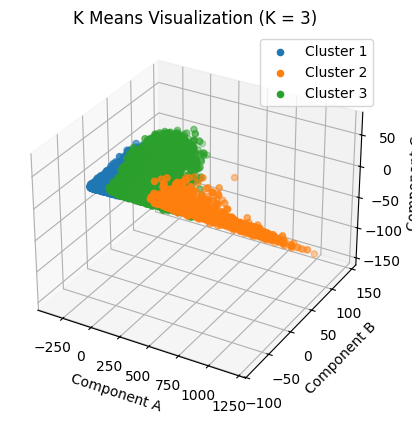

In [121]:
# TODO: Call your implementation of kmeans using the new pca value, store the 
# result in a variable, then call visualize_clusters() on it!
from sklearn import decomposition

iterations = 10  
DIMENSIONS = 3
pca = pd.DataFrame(decomposition.PCA(DIMENSIONS).fit_transform(df))

clusters = kmeans(DIMENSIONS, pca, iterations)
visualize_clusters(clusters)

## Part 4: Correlation with PCA and Variables
Looking good! The box above should've been populated by a few different clusters, depending on your optimal *k* (though it's possible you may have to run it a few times due to the random centroid placement). Now let's see how different variables affect the clustering!

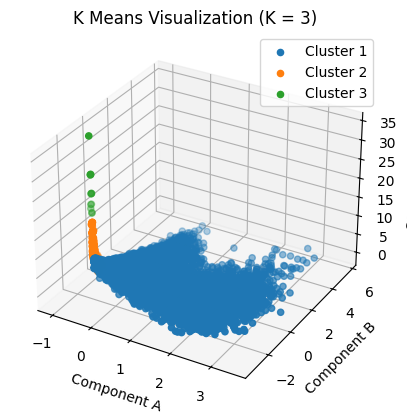

            PC1       PC2        ERA  Cluster
0      0.319016  1.341971  -0.290195        0
1     -0.656060 -0.736016   0.197592        0
2      0.310030  0.793059  -0.393381        0
3     -0.135167  1.060043  -0.327717        0
4      0.838166 -0.321331  -0.391504        0
...         ...       ...        ...      ...
15813 -1.039151 -0.572403  24.328038        2
15995 -1.042716 -0.551947  19.262558        2
16335 -1.042621 -0.519725  19.262558        2
17295 -1.031275 -0.581333  14.197078        2
18345 -1.009708 -0.713733  15.885571        2

[18507 rows x 4 columns]
Average ERA by cluster:
Cluster
1    -0.118784
2     3.418162
3    20.050522
Name: ERA, dtype: float64


In [122]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math
import matplotlib.pyplot as plt
import numpy as np
import random


def to_pca(dimensions: int, data: pd.DataFrame, new_vector):
    """
    Performs dimensionality reduction on a given dataset and appends an additional column.
    
    Arguments:
        dimensions (int): the number of PCA components to extract.
        data (pd.DataFrame): the dataset to transform.
        new_vector: the additional vector (e.g., salary) to append (as a numpy array, not a Series).
    
    Returns:
        pd.DataFrame: a DataFrame containing the PCA components and the appended new vector, all standardized.
    """
    # TODO: Run PCA on the data down to the specified "dimensions" variable using the decomposition.PCA().fit_transform() method
    pca_transformed = decomposition.PCA(n_components=dimensions).fit_transform(data)

    
    # TODO: Append the new_vector column onto the new pca variable, giving it a total of dimensions + 1
    column_names = [f'PC{i+1}' for i in range(dimensions)]
    pca_df = pd.DataFrame(pca_transformed, columns=column_names)
    
    pca_df['ERA'] = new_vector

    # TODO: Standardize the dimensions of your new pca variable using the StandardScalar library, 
    # then transform it back into a DataFrame

        # Making your data "standard" is a typical practice, especially when your data values have different
    # scales (for example, feature 1 might have points between [0-10] while feature 2 has points between [0-1000])

    scaler = StandardScaler()
    pca_standardized = scaler.fit_transform(pca_df)
    pca_final_df = pd.DataFrame(pca_standardized, columns=pca_df.columns)
    
    # TODO: Return the new PCA dataframe!
    return pca_final_df


# TODO: Using the above function, use PCA to reduce your dimensions down to 2, then append the ERA vector we
# declared in the data preprocessing section!
pca_data = to_pca(dimensions=2, data=df, new_vector=era_vector)


# TODO: Run your kmeans implementation on the new pca variable returned by to_pca(), and be 
# sure to plot it using visualize_clusters()!
def initalize_points(num_clusters: int, data: pd.DataFrame):
    ''' 
    Initializes random starting positions for each cluster's centroid. Each value in each point should 
    be rounded to two digits (i.e. x=10.72, y=4.36, etc.)

    Arguments:
        num_clusters (int): the total amount of clusters the k-means algorithm is looking for
        dimensions (int): the total amount of features

    Returns: 
        a list of points in the given dimension space [(x, y, z, ...), ...] 
    '''
    centroids = [] 
    features = data.columns
    
    for i in range(num_clusters):  
        centroid = [] 
        # for each cluster selecting a random centroid value
        #getting a random value between the min and max value of each feature
        #each random value together forms centroid
        for feature in features:
            min_value = data[feature].min()
            max_value = data[feature].max()
            random_value = round(np.random.uniform(min_value, max_value), 2)
            centroid.append(random_value)
        centroids.append(centroid)
    
    return centroids

def distance(point1: list[float], point2: list[float]):
    '''
    Given two points in the given dimension space (x, y, z, ...), calculates the euclidean distance between them

    Arguments:
        point1: a list of floating point numbers representing a point in the given dimension space
        point2: a list of floating point numbers representing a point in the given dimension space 

    Returns:
        the euclidean distance between point1 and point2

    '''
    # If you are unfamiliar with calculating distance in any dimension space, this link may be helpful:
    # https://www.geeksforgeeks.org/euclidean-distance/#:~:text=Euclidean%20Distance%20in%20nD
    
    inside_sum = 0  

    #euclidean distance between point 1 and point 2
    for i in range(len(point1)):
        difference = point1[i] - point2[i]
        inside_sum += difference ** 2 
    return math.sqrt(inside_sum)

def assign_clusters(centroids: list[list[float]], data: pd.DataFrame):
    '''
    Calculates the distance between every datapoint and every centroid. Assigns a cluster
    to a datapoint if that cluster's centroid is the closest. 

    Arguments:
        centroids (list[list[float]]): A list of points in given dimension space [(x, y, z, ...), ...] that represent the center of a cluster
        data (pd.DataFrame): the input data

    Returns:
        a copy of the data with a "cluster" column which assigns a cluster to each datapoint
    '''
    cluster_assignments = []  

    for data_point in range(len(data)): 
        point = data.iloc[data_point].values.tolist()  
        closest_cluster = None  
        min_distance = float('inf') 

        #calculating distance between each data point and current centroid
        for i in range(len(centroids)): 
            centroid = centroids[i]  
            distance_point_centroid = distance(point, centroid) 
            if distance_point_centroid < min_distance:  
                min_distance = distance_point_centroid 
                #index of centroid with minimum distance is the data points assigned cluster
                closest_cluster = i 
        cluster_assignments.append(closest_cluster)

    df_with_cluster = data.copy()
    df_with_cluster['Cluster'] = cluster_assignments

    return df_with_cluster

def move_centroids(centroids: list[list[float]], data: pd.DataFrame):
    '''
    Moves all centroids to the midpoint of their respective datapoints. 
    HINT: Average each column's values respective to each cluster!

    Arguments:
        centroids (list[list[float]]): A list of points in given dimension space [(x, y, z, ...), ...] that represent the center of a cluster
        data (pd.DataFrame): the input data 
    '''

    #data in the cluster column is grouped by clusters
    #calculating the mean of each feature for each cluster
    grouped_means = data.groupby("Cluster").mean()

    new_centroids = []
    for i in range(len(centroids)):
        #for each exisiting centroid, if the cluster exists in grouped means, the mean values of the points for that cluster become the new centroid
        if i in grouped_means.index:
            new_centroids.append(grouped_means.loc[i].tolist())
        #if the cluster has no assigned points, the centroid is not changed
        else:
            new_centroids.append(centroids[i])
    
    return new_centroids

def kmeans(num_clusters: int, data: pd.DataFrame, num_iterations: int):
    '''
    Implementation of the k-means algorithm. Consists of the following steps:
    1. Initialize a set of points to be the centroids of the clusters
    2. Iterate for num_iterations times:
        * Assign clusters to datapoints 
        * Move all centroids relative to their assigned datapoints
    3. Return a list of clusters with their assigned datapoints 

    Arguments:
        num_clusters (int): the total amount of clusters the k-means algorithm is looking for
        data (pd.DataFrame): the input data
        num_iterations (int): the total amount of times we move and assign clusters 

    Returns:
        a list of dataframes, each dataframe representing a cluster of datapoints
    '''
    #getting starting random centroids
    centroids = initalize_points(num_clusters, data)
    
    #assign initial clusters
    #find new centroid locations based on current assignments
    for i in range(num_iterations):
        data_with_clusters = assign_clusters(centroids, data)
        centroids = move_centroids(centroids, data_with_clusters)

    #groups data points into final clusters
    clusters = []    
    for i in range(num_clusters):
        cluster_data = data_with_clusters[data_with_clusters["Cluster"] == i]
        clusters.append(cluster_data)
    
    return clusters

clusters_list = kmeans(num_clusters=3, data=pca_data, num_iterations=10)
visualize_clusters(clusters_list)

#for testing and writeup
data_with_clusters = pd.concat(clusters_list)

mean_era_by_cluster = data_with_clusters.groupby('Cluster')['ERA'].mean()
mean_era_by_cluster.index = mean_era_by_cluster.index + 1
print(data_with_clusters)
print("Average ERA by cluster:")
print(mean_era_by_cluster)

Though you may have to run your clustering algorithm a few times due to random centroid placement, you should see a very obvious connection between cluster assignment and "Component C", or our ERA value. But to what extent are the two related? Let's find out through correlation!

In [123]:
def merge_clusters(clusters: list[pd.DataFrame]):
    '''
    Used to merge clusters into a single dataframe.

    Arguments:
        clusters (list[pd.DataFrame]): a list of clusters as returns by the k-means algorithm

    Returns:
        a single dataframe with all the clusters appended to it
    '''
    final_clusters = pd.DataFrame()
    for cluster in clusters:
        final_clusters = pd.concat([final_clusters, cluster])
    return final_clusters

# TODO: Find the correlation between the ERA value and its assignment!
correlation = data_with_clusters['ERA'].corr(data_with_clusters['Cluster'])
print(correlation)

0.7436476618073805


The correlation between the cluster assignment and our ERA value should be the highest!

Now, let's examine salaries! This will take a bit more work as we'll need to combine datasets on two keys. Salaries are determined both by year and by player, so we'll need the *playerID* key and the *yearID* key.

In [124]:
# TODO: Access both .csv files, convert to dataframes. 
# Then, merge both dataframes on the two keys mentioned in the markdown cell above.
salaries = pd.read_csv("salaries.csv")
pitching = pd.read_csv("pitching.csv")
merged_data = pd.merge(pitching, salaries, on=["playerID", "yearID"], how="left")
print(merged_data.columns)

# TODO: Perform the same preprocessing steps as in the first cell. 
# **this time, however, save the salary column rather than the ERA column**

# TODO: drop any year before 1985
merged_data = merged_data[merged_data["yearID"] >= 1985]

# TODO: drop the first five columns
merged_data = merged_data.drop(columns=merged_data.columns[:5])

# TODO: drop the last 3 columns
merged_data = merged_data.drop(columns=['GIDP', 'teamID_y', 'lgID_y'])

# TODO: drop blank / na rows
merged_data = merged_data.dropna().reset_index(drop=True)

# TODO: save salary into its own vector, then drop it from the dataframe
salary_vector = merged_data['salary']
merged_data = merged_data.drop(columns=['salary'])

#for testing 
print(merged_data.head()) 
print(salary_vector.head())

Index(['playerID', 'yearID', 'stint', 'teamID_x', 'lgID_x', 'W', 'L', 'G',
       'GS', 'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP',
       'teamID_y', 'lgID_y', 'salary'],
      dtype='object')
   W  L   G  GS  CG  SHO  SV  IPouts    H  ER  ...   ERA  IBB   WP  HBP  BK  \
0  9  7  35  27   0    0   0   537.0  164  84  ...  4.22  4.0  3.0  5.0   0   
1  3  7  62   0   0    0   0   248.0   77  35  ...  3.81  9.0  3.0  1.0   2   
2  6  9  66   0   0    0   2   253.0   80  33  ...  3.52  0.0  5.0  0.0   0   
3  1  2  54   0   0    0  29   143.0   47  26  ...  4.91  2.0  1.0  4.0   0   
4  1  3  23   0   0    0   0    61.0   23  13  ...  5.75  0.0  1.0  1.0   0   

     BFP    GF   R   SH   SF  
0  766.0   2.0  89  1.0  4.0  
1  347.0  18.0  38  1.0  1.0  
2  369.0  18.0  42  3.0  0.0  
3  210.0  44.0  28  1.0  0.0  
4   95.0   5.0  14  1.0  2.0  

[5 rows x 24 columns]
0     285000.0
1     

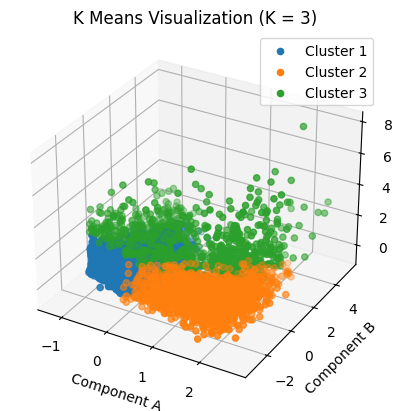

           PC1       PC2    salary  Cluster
1    -0.004551  0.460014 -0.573451        0
2     0.057645  0.539154 -0.362697        0
3    -0.505058  0.739438  0.199313        0
4    -0.918532 -0.231742 -0.576797        0
5    -0.147741  0.975997 -0.635674        0
...        ...       ...       ...      ...
6883  1.809449  0.182855  1.269810        2
6886 -0.850388 -0.322579  4.481301        2
6891  1.162459 -1.077625  4.079864        2
6894  0.748651  0.094608  4.079864        2
6907  1.780365  0.250078  3.678428        2

[6908 rows x 4 columns]
Cluster Means:
Cluster
1   -0.336159
2   -0.123685
3    2.346657
Name: salary, dtype: float64


In [125]:
# TODO: As before, run the to_pca() function with 2 dimensions, but this time, append the new salaries vector!
pca_data_salary = to_pca(dimensions=2, data=merged_data, new_vector=salary_vector)
pca_data_salary.rename(columns={'ERA': 'salary'}, inplace=True)


# TODO: Run the k-means algorithm on the new PCA representation, then visualize those clusters!
# TODO: Implement the K-Means algorithm. You're given starter functions, declarations, 
# and some code to get you started. The final implementation is up to you, but keep in
# mind that the visualization function we've built for you expects a list of pandas
# dataframes. Even though we provide method signatures, you may change them however you
# please. You're also free to change the visualization function to adapt to your changes, 
# but we feel it would be best to return the clusters from the K-Means function as a list 
# of dataframes. 

# You will be asked to generate a kmeans algorithm that works across all dimension spaces
# (i.e. 2D, 3D, etc.). Due to the sheer amount of features available in the pitching
# dataset, we want to be able to use clustering on every datapoint and every feature.

def initalize_points(num_clusters: int, data: pd.DataFrame):
    ''' 
    Initializes random starting positions for each cluster's centroid. Each value in each point should 
    be rounded to two digits (i.e. x=10.72, y=4.36, etc.)

    Arguments:
        num_clusters (int): the total amount of clusters the k-means algorithm is looking for
        dimensions (int): the total amount of features

    Returns: 
        a list of points in the given dimension space [(x, y, z, ...), ...] 
    '''
    centroids = [] 
    features = data.columns
    
    for i in range(num_clusters):  
        centroid = [] 
        # for each cluster selecting a random centroid value
        #getting a random value between the min and max value of each feature
        #each random value together forms centroid
        for feature in features:
            min_value = data[feature].min()
            max_value = data[feature].max()
            random_value = round(np.random.uniform(min_value, max_value), 2)
            centroid.append(random_value)
        centroids.append(centroid)
    
    return centroids

def distance(point1: list[float], point2: list[float]):
    '''
    Given two points in the given dimension space (x, y, z, ...), calculates the euclidean distance between them

    Arguments:
        point1: a list of floating point numbers representing a point in the given dimension space
        point2: a list of floating point numbers representing a point in the given dimension space 

    Returns:
        the euclidean distance between point1 and point2

    '''
    # If you are unfamiliar with calculating distance in any dimension space, this link may be helpful:
    # https://www.geeksforgeeks.org/euclidean-distance/#:~:text=Euclidean%20Distance%20in%20nD
    
    inside_sum = 0  

    #euclidean distance between point 1 and point 2
    for i in range(len(point1)):
        difference = point1[i] - point2[i]
        inside_sum += difference ** 2 
    return math.sqrt(inside_sum)

def assign_clusters(centroids: list[list[float]], data: pd.DataFrame):
    '''
    Calculates the distance between every datapoint and every centroid. Assigns a cluster
    to a datapoint if that cluster's centroid is the closest. 

    Arguments:
        centroids (list[list[float]]): A list of points in given dimension space [(x, y, z, ...), ...] that represent the center of a cluster
        data (pd.DataFrame): the input data

    Returns:
        a copy of the data with a "cluster" column which assigns a cluster to each datapoint
    '''
    cluster_assignments = []  

    for data_point in range(len(data)): 
        point = data.iloc[data_point].values.tolist()  
        closest_cluster = None  
        min_distance = float('inf') 

        #calculating distance between each data point and current centroid
        for i in range(len(centroids)): 
            centroid = centroids[i]  
            distance_point_centroid = distance(point, centroid) 
            if distance_point_centroid < min_distance:  
                min_distance = distance_point_centroid 
                #index of centroid with minimum distance is the data points assigned cluster
                closest_cluster = i 
        cluster_assignments.append(closest_cluster)

    df_with_cluster = data.copy()
    df_with_cluster['Cluster'] = cluster_assignments

    return df_with_cluster

def move_centroids(centroids: list[list[float]], data: pd.DataFrame):
    '''
    Moves all centroids to the midpoint of their respective datapoints. 
    HINT: Average each column's values respective to each cluster!

    Arguments:
        centroids (list[list[float]]): A list of points in given dimension space [(x, y, z, ...), ...] that represent the center of a cluster
        data (pd.DataFrame): the input data 
    '''

    #data in the cluster column is grouped by clusters
    #calculating the mean of each feature for each cluster
    grouped_means = data.groupby("Cluster").mean()

    new_centroids = []
    for i in range(len(centroids)):
        #for each exisiting centroid, if the cluster exists in grouped means, the mean values of the points for that cluster become the new centroid
        if i in grouped_means.index:
            new_centroids.append(grouped_means.loc[i].tolist())
        #if the cluster has no assigned points, the centroid is not changed
        else:
            new_centroids.append(centroids[i])
    
    return new_centroids

def kmeans(num_clusters: int, data: pd.DataFrame, num_iterations: int):
    '''
    Implementation of the k-means algorithm. Consists of the following steps:
    1. Initialize a set of points to be the centroids of the clusters
    2. Iterate for num_iterations times:
        * Assign clusters to datapoints 
        * Move all centroids relative to their assigned datapoints
    3. Return a list of clusters with their assigned datapoints 

    Arguments:
        num_clusters (int): the total amount of clusters the k-means algorithm is looking for
        data (pd.DataFrame): the input data
        num_iterations (int): the total amount of times we move and assign clusters 

    Returns:
        a list of dataframes, each dataframe representing a cluster of datapoints
    '''
    #getting starting random centroids
    centroids = initalize_points(num_clusters, data)
    
    #assign initial clusters
    #find new centroid locations based on current assignments
    for i in range(num_iterations):
        data_with_clusters = assign_clusters(centroids, data)
        centroids = move_centroids(centroids, data_with_clusters)

    #groups data points into final clusters
    clusters = []    
    for i in range(num_clusters):
        cluster_data = data_with_clusters[data_with_clusters["Cluster"] == i]
        clusters.append(cluster_data)
    
    return clusters
import matplotlib.pyplot as plt

def visualize_clusters(clusters: list[pd.DataFrame]):
    '''
    Visualizes the list of clusters provided in a 3D projection. Separates clusters into color groupings.

    Arguments:
        clusters (list[pd.DataFrame]): a list of clusters provided by running the k-means algorithm 
    '''
    # plot clusters
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    # add each cluster to graph and legend
    for i, cluster in enumerate(clusters):
        ax.scatter(cluster.iloc[:,0], cluster.iloc[:,1], cluster.iloc[:,2], label=f'Cluster {i+1}')
    ax.set_xlabel("Component A")
    ax.set_ylabel("Component B")
    ax.set_zlabel("Component C")
    plt.title(f'K Means Visualization (K = {len(clusters)})')
    # add legend
    ax.legend()  
    plt.show()

pca_data_salary = to_pca(dimensions=2, data=merged_data, new_vector=salary_vector)
pca_data_salary.rename(columns={'ERA': 'salary'}, inplace=True)
clusters_list_salary = kmeans(num_clusters=3, data=pca_data_salary, num_iterations=10)
visualize_clusters(clusters_list_salary)

data_with_clusters = pd.concat(clusters_list_salary)

#for testing and writeup
cluster_means = data_with_clusters.groupby('Cluster')['salary'].mean()
cluster_means.index = cluster_means.index + 1

print(data_with_clusters)
print("Cluster Means:")
print(cluster_means)